In [75]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import yaml
from matplotlib.lines import Line2D
from shapely.geometry import Point, Polygon

ox.settings.use_cache = True
ox.settings.log_console = False

with open("../plotting_config.yaml") as fp:
    config = yaml.safe_load(fp)

In [4]:
def plot(land, street, railway, bus, trolley, stopes, layers=[0]):
    fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
    if 0 in layers:
        gpd.clip(land, area).plot(color=config["colors"]["land"], ax=ax, zorder=0)
        gpd.clip(street, area).plot(color=config["colors"]["street"], ax=ax, zorder=1)
    if 1 in layers:
        gpd.clip(railway.query("railway=='tram'"), area).plot(
            color=config["colors"]["tram"], lw=5, ax=ax, zorder=5
        )
    if 2 in layers:
        gpd.clip(railway.query("railway=='subway'"), area).plot(
            color=config["colors"]["m4"], lw=5, ax=ax, zorder=4
        )
    if 3 in layers:
        gpd.clip(bus[bus.geom_type.isin(["LineString", "MultiLineString"])], area).plot(
            color=config["colors"]["bus"], lw=5, ax=ax, zorder=5
        )
    if 4 in layers:
        gpd.clip(
            trolley[
                trolley.geom_type.isin(["LineString", "MultiLineString"])
            ],  # .buffer(1, cap_style=2),
            area,
        ).plot(color=config["colors"]["trolley"], lw=5, ax=ax, zorder=5)
    if 5 in layers:
        gpd.clip(stops, area).plot(color="#2d2d2d", lw=5, ax=ax, zorder=10)

    ax.margins(0)
    ax.axis("off")
    return fig, ax


def create_legend():
    legend_elements = []
    labels = ["tram", "subway", "bus", "trolley"]
    lcolors = [
        config["colors"][i] if i != "subway" else config["colors"]["m4"] for i in labels
    ]
    for l, c in zip(labels, lcolors):
        elem = Line2D([0], [0], color=c, lw=4, linestyle="solid", label=l)
        legend_elements.append(elem)
    stop = Line2D(
        [0], [0], color="#2d2d2d", lw=4, linestyle="none", marker="o", label="stop"
    )
    legend_elements.append(stop)
    return legend_elements

In [97]:
duna = gpd.read_file("../data/geojson/duna_budapest.geojson", engine="pyogrio")
duna.to_crs(23700, inplace=True)

In [6]:
railway = ox.features_from_point(
    (47.4868, 19.057), tags={"railway": ["subway", "tram"]}, dist=500
)
railway.to_crs(23700, inplace=True)

In [ ]:
# # type=route+route=bus/route=trolleybus
# bus = ox.features_from_point(
#     (47.4868, 19.057),
#     tags={"route": "bus"},
#     dist=500,
# )
# bus.to_crs(23700, inplace=True)

In [10]:
bridge = ox.features_from_point(
    (47.4868, 19.057), tags={"name": "Szabadság híd"}, dist=750
)
bridge.to_crs(23700, inplace=True)
bridge = (
    bridge[bridge["geometry"].geom_type.isin(["Polygon", "MultiPolygon"])]
    .reset_index()
    .copy()
)
bridge = bridge["geometry"][0]

In [11]:
streets = ox.features_from_point((47.4868, 19.057), tags={"highway": True}, dist=500)
streets = streets[
    streets["geometry"].geom_type.isin(["LineString", "MultiLineString"])
].copy()
streets.to_crs(23700, inplace=True)

In [12]:
bus = gpd.read_file("../data/geojson/route_b.geojson", engine="pyogrio")
bus.to_crs(23700, inplace=True)
trolley = gpd.read_file("../data/geojson/route_tb.geojson", engine="pyogrio")
trolley.to_crs(23700, inplace=True)

/home/gergo/.cache/pypoetry/virtualenvs/calculate_accessibility-4Q_DyPin-py3.11/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/gergo/.cache/pypoetry/virtualenvs/calculate_accessibility-4Q_DyPin-py3.11/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/gergo/.cache/pypoetry/virtualenvs/calculate_accessibility-4Q_DyPin-py3.11/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_date

In [52]:
minx = 650700 - 100
miny = 238080 - 100
ax = 250
ay = 250

In [53]:
area = Polygon(
    [
        Point(minx, miny),
        Point(minx + ax, miny),
        Point(minx + ax, miny + ay),
        Point(minx, miny + ay),
    ]
)
land = area - duna.geometry[0]
land = land.union(bridge)
land = gpd.GeoDataFrame(geometry=[land], crs=23700)

In [ ]:
# fig, _ = plot(land, streets, None, None, None, None, layers=[0])
# for i in config["formats"]:
#     fig.savefig(
#         f"../figures/fovam.{i}",
#         dpi=300,
#         facecolor="white",
#         pad_inches=0,
#         metadata=config["metadata"][i],
#     )

In [ ]:
# fig_t, ax_t = plot(land, streets, railway, None, None, None, layers=[0, 1])

# ax_t.margins(0)
# ax_t.axis("off")
# for i in config["formats"]:
#     fig_t.savefig(
#         f"../figures/fovam_tram.{i}",
#         dpi=300,
#         facecolor="white",
#         pad_inches=0,
#         metadata=config["metadata"][i],
#     )

In [ ]:
# fig_ts, _ = plot(land, streets, railway, None, None, None, layers=[0, 1, 2])
# for i in config["formats"]:
#     fig_ts.savefig(
#         f"../figures/fovam_tram_subway.{i}",
#         dpi=300,
#         facecolor="white",
#         pad_inches=0,
#         metadata=config["metadata"][i],
#     )

In [ ]:
# fig_tsb, _ = plot(
#     land, streets, railway, bus.translate(-2, 0), None, None, layers=[0, 1, 2, 3]
# )
# for i in config["formats"]:
#     fig_tsb.savefig(
#         f"../figures/fovam_tram_subway_bus.{i}",
#         dpi=300,
#         facecolor="white",
#         pad_inches=0,
#         metadata=config["metadata"][i],
#     )

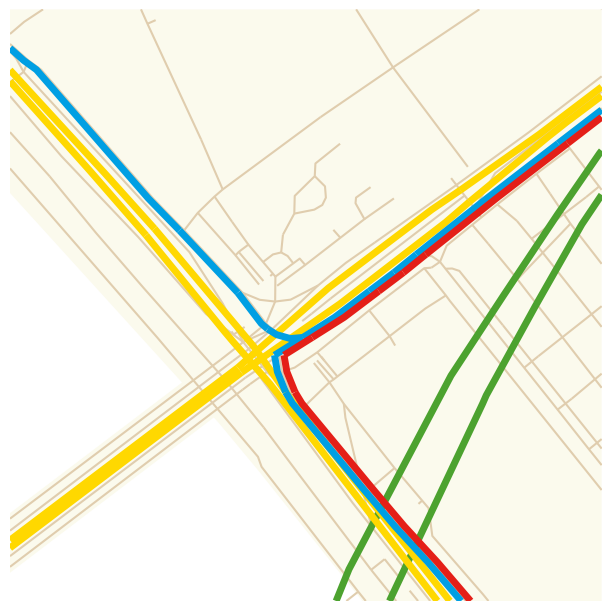

In [98]:
fig_tsbt, _ = plot(
    land,
    streets,
    railway,
    bus.translate(-2, 0),
    trolley.translate(2, 0),
    None,
    layers=[0, 1, 2, 3, 4],
)
# for i in config["formats"]:
#     fig_tsbt.savefig(
#         f"../figures/fovam_tram_subway_bus_trolley.{i}",
#         dpi=300,
#         facecolor="white",
#         pad_inches=0,
#         metadata=config["metadata"][i],
#     )

In [55]:
stops = pd.concat(
    [
        bus.query("highway=='bus_stop'"),
        trolley.query("highway=='bus_stop'"),
    ]
)
stops.rename({"@id": "osmid", "@type": "element_type"}, axis=1, inplace=True)

In [56]:
rw_stops = ox.features_from_point(
    (47.4868, 19.057),
    tags={"railway": ["tram_stop"], "station": ["subway"], "highway": ["bus_stop"]},
    dist=500,
).reset_index()
rw_stops.to_crs(23700, inplace=True)

In [61]:
rw_stops.rename({"element": "element_type", "id": "osmid"}, axis=1, inplace=True)

In [62]:
stops = pd.concat(
    [
        stops[["element_type", "osmid", "name", "geometry", "railway", "highway"]],
        rw_stops[["element_type", "osmid", "name", "geometry", "railway", "station"]],
    ]
)

In [63]:
stops = rw_stops[
    ["element_type", "osmid", "name", "geometry", "railway", "station"]
].copy()

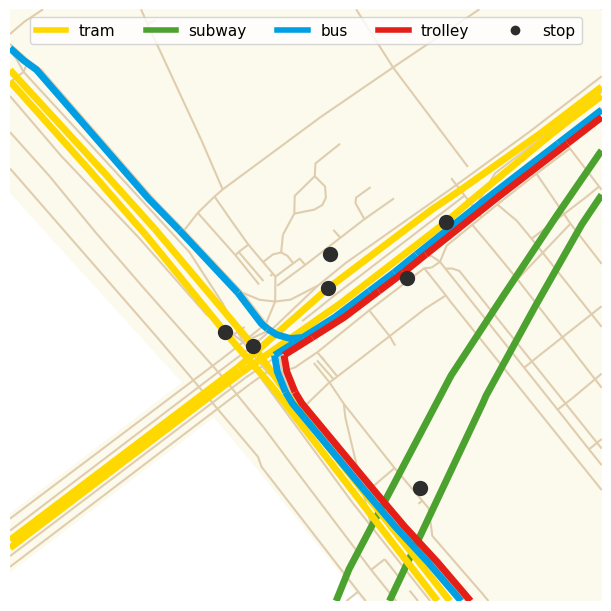

In [64]:
fig2, ax2 = plot(
    land,
    streets,
    railway,
    bus.translate(-2, 0),
    trolley.translate(2, 0),
    stops,
    layers=[0, 1, 2, 3, 4, 5],
)
ax2.legend(handles=create_legend(), ncols=5, loc="upper center", fontsize=11)
# for i in config["formats"]:
#     fig2.savefig(
#         f"../figures/fovam_with_stops.{i}",
#         dpi=300,
#         facecolor="white",
#         pad_inches=0,
#         metadata=config["metadata"][i],
#     )

In [65]:
fovam_stops = gpd.clip(stops, area)
merged = gpd.GeoDataFrame(geometry=[fovam_stops.union_all().centroid], crs=23700)

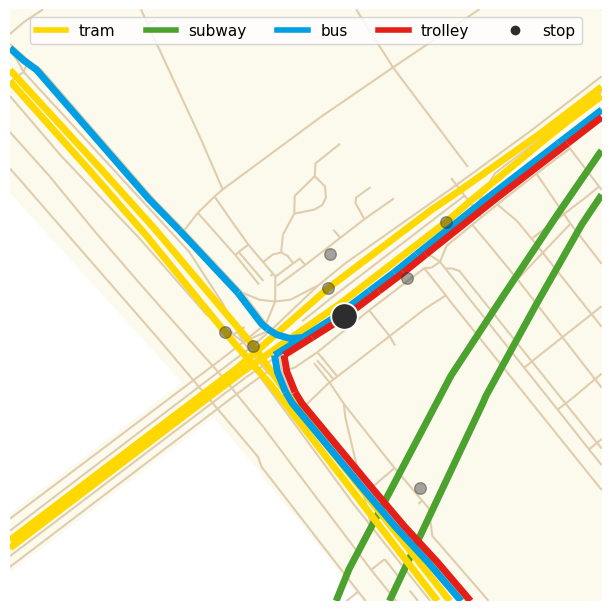

In [86]:
fig3, ax3 = plot(
    land,
    streets,
    railway,
    bus.translate(-2, 0),
    trolley.translate(2, 0),
    None,
    layers=[0, 1, 2, 3, 4],
)
fovam_stops.plot(color="#2d2d2d6d", markersize=70, ax=ax3, zorder=15)
merged.plot(color="#ffffff", markersize=380, ax=ax3, zorder=20)
merged.plot(color="#2d2d2d", markersize=280, ax=ax3, zorder=21)

ax3.legend(handles=create_legend(), ncols=5, loc="upper center", fontsize=11)

for i in config["formats"]:
    fig3.savefig(
        f"../.github/fovam_stop_centroid.{i}",
        dpi=150,
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"][i],
    )

In [ ]:
# based on: https://stackoverflow.com/a/38022636/4737417
def distance_matrix(data: pd.DataFrame):
    result = []
    for i in data.itertuples():
        r = []
        for j in data.itertuples():
            d = np.round(i.geometry.distance(j.geometry))
            r.append(d)
        result.append(r)
    result = np.array(result)
    return result


def medoid_index(distamce_matrix: np.array) -> int:
    return int(np.argmin(distamce_matrix.sum(axis=0)))


def calculate_medoid(data: pd.DataFrame, id_column: str = "stop_id") -> int:
    dmx = distance_matrix(data)
    i = int(np.argmin(dmx.sum(axis=0)))
    return data[id_column].tolist()[i]

In [ ]:
medoid_stopid = calculate_medoid(fovam_stops, "osmid")
medoid = fovam_stops[fovam_stops["osmid"] == medoid_stopid].copy()

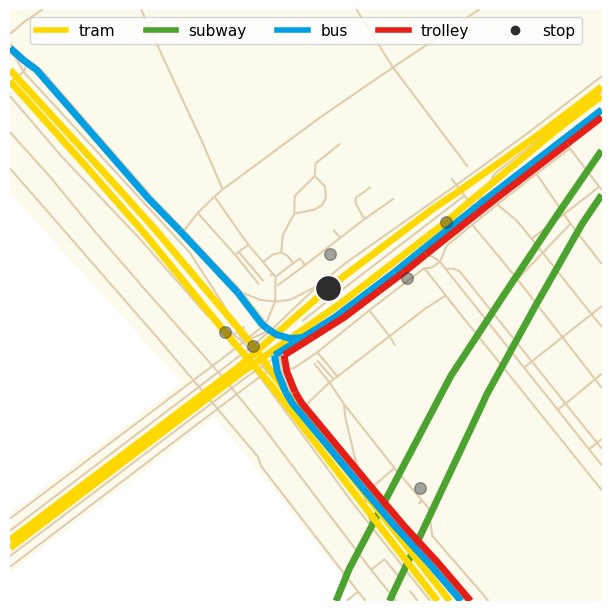

In [87]:
fig4, ax4 = plot(
    land,
    streets,
    railway,
    bus.translate(-2, 0),
    trolley.translate(2, 0),
    None,
    layers=[0, 1, 2, 3, 4],
)
fovam_stops.plot(color="#2d2d2d6d", markersize=70, ax=ax4, zorder=15)
medoid.plot(color="#ffffff", markersize=380, ax=ax4, zorder=20)
medoid.plot(color="#2d2d2d", markersize=280, ax=ax4, zorder=21)

ax4.legend(handles=create_legend(), ncols=5, loc="upper center", fontsize=11)

for i in config["formats"]:
    fig4.savefig(
        f"../.github/fovam_stop_medoid.{i}",
        dpi=150,
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"][i],
    )